### Dependencies

In [33]:
import argparse
import numpy as np
import pandas as pd

import datetime
import calendar

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

### Import Data

In [47]:
df = pd.read_csv('KaggleV2-May-2016 2.csv')
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

### Feature Extraction

In [3]:
schedule_dates = df['ScheduledDay'].to_numpy()
schedule_dates

array(['2016-04-29T18:38:08Z', '2016-04-29T16:08:27Z',
       '2016-04-29T16:19:04Z', ..., '2016-04-27T16:03:52Z',
       '2016-04-27T15:09:23Z', '2016-04-27T13:30:56Z'], dtype=object)

In [4]:
appointment_dates = df['AppointmentDay'].to_numpy()
appointment_dates

array(['2016-04-29T00:00:00Z', '2016-04-29T00:00:00Z',
       '2016-04-29T00:00:00Z', ..., '2016-06-07T00:00:00Z',
       '2016-06-07T00:00:00Z', '2016-06-07T00:00:00Z'], dtype=object)

In [5]:
gender = df['Gender'].to_numpy()
gender

array(['F', 'M', 'F', ..., 'F', 'F', 'F'], dtype=object)

In [6]:
num_days_inbetween = []
schedule_hour = []
appo_weekday = []
gender_encoded = []
# 
for i in range(len(df)):
        schedDate_obj = datetime.datetime.strptime(schedule_dates[i], "%Y-%m-%dT%H:%M:%SZ")
        appointDate_obj = datetime.datetime.strptime(appointment_dates[i], "%Y-%m-%dT%H:%M:%SZ")
        schedule_hour.append(schedDate_obj.hour)
        schedDate_obj = schedDate_obj.replace(hour=0, minute=0, second=0, microsecond=0)
        appointDate_obj = appointDate_obj.replace(hour=0, minute=0, second=0, microsecond=0)
        deltaT = appointDate_obj - schedDate_obj
        if gender[i] == 'M':
            gender_encoded.append(1)
        else:
            gender_encoded.append(0)
        num_days_inbetween.append(deltaT.days)
        appo_weekday.append(calendar.day_name[appointDate_obj.weekday()])

In [7]:
#extract scheduled hour
df['ScheduledHour'] = schedule_hour
df['ScheduledHour']

0         18
1         16
2         16
3         17
4         16
          ..
110522     9
110523     7
110524    16
110525    15
110526    13
Name: ScheduledHour, Length: 110527, dtype: int64

In [8]:
# extract number of days in between schedule date and appointment date
df['Days_in_between'] = num_days_inbetween
df['Days_in_between']

0          0
1          0
2          0
3          0
4          0
          ..
110522    35
110523    35
110524    41
110525    41
110526    41
Name: Days_in_between, Length: 110527, dtype: int64

In [9]:
# extract the weekday of the appointment
df['AppointmentWeekday'] = appo_weekday
df['AppointmentWeekday']

0          Friday
1          Friday
2          Friday
3          Friday
4          Friday
           ...   
110522    Tuesday
110523    Tuesday
110524    Tuesday
110525    Tuesday
110526    Tuesday
Name: AppointmentWeekday, Length: 110527, dtype: object

In [10]:
# One-hot Encoding for gender variable
df['Gender'] = gender_encoded
df['Gender']

0         0
1         1
2         0
3         0
4         0
         ..
110522    0
110523    0
110524    0
110525    0
110526    0
Name: Gender, Length: 110527, dtype: int64

In [11]:
#drop columns
df = df.drop(columns=['PatientId','AppointmentID','ScheduledDay', 'AppointmentDay', 'Neighbourhood'])
df = df[(df['Age'] >= 0) & (df['Days_in_between'] >= 0)]
df

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledHour,Days_in_between,AppointmentWeekday
0,0,62,0,1,0,0,0,0,No,18,0,Friday
1,1,56,0,0,0,0,0,0,No,16,0,Friday
2,0,62,0,0,0,0,0,0,No,16,0,Friday
3,0,8,0,0,0,0,0,0,No,17,0,Friday
4,0,56,0,1,1,0,0,0,No,16,0,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...
110522,0,56,0,0,0,0,0,1,No,9,35,Tuesday
110523,0,51,0,0,0,0,0,1,No,7,35,Tuesday
110524,0,21,0,0,0,0,0,1,No,16,41,Tuesday
110525,0,38,0,0,0,0,0,1,No,15,41,Tuesday


In [12]:
encoder = OneHotEncoder(sparse=False)
encodeArr = encoder.fit_transform(df[['AppointmentWeekday']])
encodeNameList = encoder.categories_[0]
encodeDf = pd.DataFrame(encodeArr, columns=encodeNameList, index=df.index.copy())
df[encodeNameList] = encodeDf[encodeNameList]

In [13]:
# One-hot Encoding for no show variable
df = df.drop(columns=['AppointmentWeekday'])
df['No-show'] = df['No-show'].replace(['No', 'Yes'], [0, 1])
df


,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledHour,Days_in_between,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday
0,0,62,0,1,0,0,0,0,0,18,0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,56,0,0,0,0,0,0,0,16,0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,62,0,0,0,0,0,0,0,16,0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,8,0,0,0,0,0,0,0,17,0,1.0,0.0,0.0,0.0,0.0,0.0
4,0,56,0,1,1,0,0,0,0,16,0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,0,56,0,0,0,0,0,1,0,9,35,0.0,0.0,0.0,0.0,1.0,0.0
110523,0,51,0,0,0,0,0,1,0,7,35,0.0,0.0,0.0,0.0,1.0,0.0
110524,0,21,0,0,0,0,0,1,0,16,41,0.0,0.0,0.0,0.0,1.0,0.0
110525,0,38,0,0,0,0,0,1,0,15,41,0.0,0.0,0.0,0.0,1.0,0.0


### Data Visualization

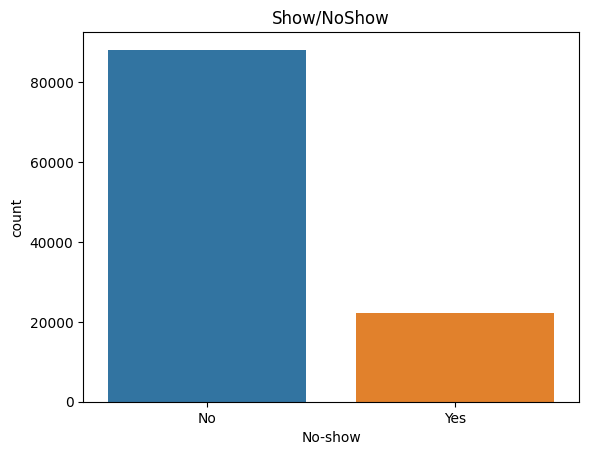

In [44]:
axis = sns.countplot(x=df['No-show'], data=df)
axis.set_title("Show/NoShow")
plt.show()

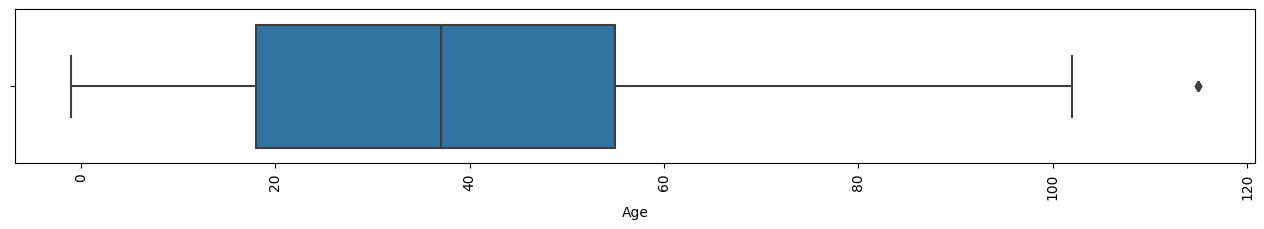

In [45]:
plt.figure(figsize=(16,2))
plt.xticks(rotation=90)
_ = sns.boxplot(x=df.Age)

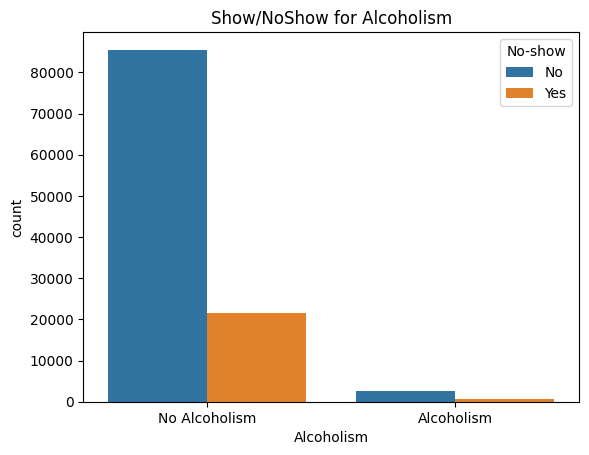

In [48]:
ax = sns.countplot(x=df['Alcoholism'], hue=df['No-show'], data=df)
ax.set_title("Show/NoShow for Alcoholism")
x_ticks_labels=['No Alcoholism', 'Alcoholism']
ax.set_xticklabels(x_ticks_labels)
plt.show()

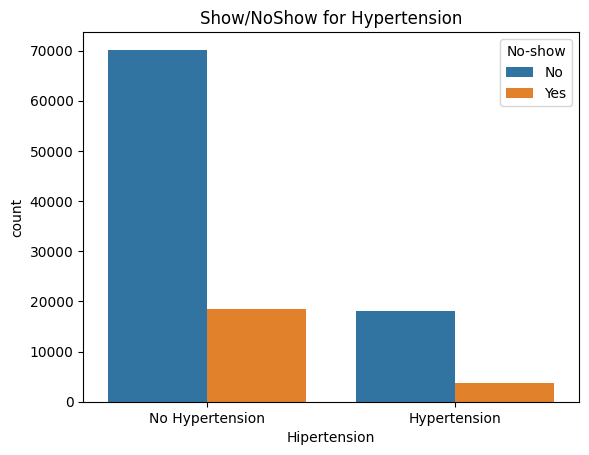

In [55]:
ax = sns.countplot(x=df['Hipertension'], hue=df['No-show'], data=df)
ax.set_title("Show/NoShow for Hypertension")
x_ticks_labels=['No Hypertension', 'Hypertension']
ax.set_xticklabels(x_ticks_labels)
plt.show()

### Data Standardization

In [14]:
stdScale = StandardScaler()
normColList = ['Age', 'Days_in_between', 'ScheduledHour']

In [15]:
normArr = stdScale.fit_transform(df[normColList])
normDf = pd.DataFrame(normArr, columns=normColList,index=df.index.copy())
df[normColList] = normDf[normColList]

### Classification Models

In [16]:
x_variables = df.loc[:, ['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes',
       'Alcoholism', 'Handcap', 'SMS_received', 'ScheduledHour',
       'Days_in_between', 'Friday', 'Monday', 'Saturday', 'Thursday',
       'Tuesday', 'Wednesday']]
x_variables

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,ScheduledHour,Days_in_between,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday
0,0,1.077925,0,1,0,0,0,0,2.246596,-0.667603,1.0,0.0,0.0,0.0,0.0,0.0
1,1,0.818295,0,0,0,0,0,0,1.624742,-0.667603,1.0,0.0,0.0,0.0,0.0,0.0
2,0,1.077925,0,0,0,0,0,0,1.624742,-0.667603,1.0,0.0,0.0,0.0,0.0,0.0
3,0,-1.258748,0,0,0,0,0,0,1.935669,-0.667603,1.0,0.0,0.0,0.0,0.0,0.0
4,0,0.818295,0,1,1,0,0,0,1.624742,-0.667603,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,0,0.818295,0,0,0,0,0,1,-0.551747,1.626714,0.0,0.0,0.0,0.0,1.0,0.0
110523,0,0.601936,0,0,0,0,0,1,-1.173601,1.626714,0.0,0.0,0.0,0.0,1.0,0.0
110524,0,-0.696215,0,0,0,0,0,1,1.624742,2.020025,0.0,0.0,0.0,0.0,1.0,0.0
110525,0,0.039404,0,0,0,0,0,1,1.313815,2.020025,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
y_label = df['No-show']
y_label

0         0
1         0
2         0
3         0
4         0
         ..
110522    0
110523    0
110524    0
110525    0
110526    0
Name: No-show, Length: 110521, dtype: int64

In [18]:
print(y_label.value_counts(normalize=True))

0    0.798102
1    0.201898
Name: No-show, dtype: float64


In [19]:
y_label = y_label.to_numpy()
y_label = y_label.reshape((y_label.shape[0],))

In [20]:
knn = KNeighborsClassifier(n_neighbors=100)
logreg = LogisticRegression(max_iter=1000)
dt = DecisionTreeClassifier(min_samples_leaf=100)
nb = GaussianNB()
percep = Perceptron()
forest = RandomForestClassifier(n_estimators=100, min_samples_leaf=10)

### Models Performances

* Accuracy

In [21]:
print(f"kNN: {cross_val_score(knn, x_variables, y_label, cv=5, scoring='accuracy').mean()}")
print(f"DecisionTree: {cross_val_score(dt, x_variables, y_label, cv=5, scoring='accuracy').mean()}")
print(f"Logistic regression: {cross_val_score(logreg, x_variables, y_label, cv=5, scoring='accuracy').mean()}")
print(f"Naive Bayes: {cross_val_score(nb, x_variables, y_label, cv=5, scoring='accuracy').mean()}")
print(f"Perceptron: {cross_val_score(percep, x_variables, y_label, cv=5, scoring='accuracy').mean()}")
print(f"Random Forest: {cross_val_score(forest, x_variables, y_label, cv=5, scoring='accuracy').mean()}")

kNN: 0.7970611887314705
DecisionTree: 0.7942562902863091
Logistic regression: 0.7933876540772117
Naive Bayes: 0.7711023114354931
Perceptron: 0.6899608615413734
Random Forest: 0.7965363923360221


* F1 Score

In [22]:
print(f"kNN: {cross_val_score(knn, x_variables, y_label, cv=5, scoring='f1').mean()}")
print(f"DecisionTree: {cross_val_score(dt, x_variables, y_label, cv=5, scoring='f1').mean()}")
print(f"Logistic regression: {cross_val_score(logreg, x_variables, y_label, cv=5, scoring='f1').mean()}")
print(f"Naive Bayes: {cross_val_score(nb, x_variables, y_label, cv=5, scoring='f1').mean()}")
print(f"Perceptron: {cross_val_score(percep, x_variables, y_label, cv=5, scoring='f1').mean()}")
print(f"Random Forest: {cross_val_score(forest, x_variables, y_label, cv=5, scoring='f1').mean()}")

kNN: 0.010271525489546384
DecisionTree: 0.05822900684417339
Logistic regression: 0.030331048091944795
Naive Bayes: 0.18047974967114389
Perceptron: 0.22192982146624635
Random Forest: 0.019702644837390013


* AUROC

In [23]:
print(f"kNN: {cross_val_score(knn, x_variables, y_label, cv=5, scoring='roc_auc').mean()}")
print(f"DecisionTree: {cross_val_score(dt, x_variables, y_label, cv=5, scoring='roc_auc').mean()}")
print(f"Logistic regression: {cross_val_score(logreg, x_variables, y_label, cv=5, scoring='roc_auc').mean()}")
print(f"Naive Bayes: {cross_val_score(nb, x_variables, y_label, cv=5, scoring='roc_auc').mean()}")
print(f"Perceptron: {cross_val_score(percep, x_variables, y_label, cv=5, scoring='roc_auc').mean()}")
print(f"Random Forest: {cross_val_score(forest, x_variables, y_label, cv=5, scoring='roc_auc').mean()}")

kNN: 0.6880876297243633
DecisionTree: 0.7094783292325479
Logistic regression: 0.6598818431504982
Naive Bayes: 0.6302847271823605
Perceptron: 0.5455955098820704
Random Forest: 0.7187280000544966


### Hyperparameter Tuning

In [52]:
t_size = 0.6
trainXs, testXs, trainys, testys = train_test_split(x_variables, y_label, test_size= t_size)

In [53]:
opt_knn = GridSearchCV(
    KNeighborsClassifier(),
    [{'n_neighbors': range(90, 150, 5), 'metric': ['euclidean', 'manhattan']}], cv=5)
opt_knn.fit(trainXs, trainys)
print(opt_knn.best_params_)
knn2 = KNeighborsClassifier(**opt_knn.best_params_)
print(f"opt_kNN: {cross_val_score(knn2, x_variables, y_label, cv=5, scoring='roc_auc').mean()}")

{'metric': 'euclidean', 'n_neighbors': 120}
opt_kNN: 0.6882975432942285


In [54]:
tree_para = [{'max_depth': range(1, 11,1),
            'criterion': ['gini', 'entropy'], 'min_samples_leaf': range(1, 11, 1)}]
opt_dt = GridSearchCV(
    DecisionTreeClassifier(),
    tree_para, cv=10)
opt_dt.fit(trainXs, trainys)
print(opt_dt.best_params_)
dt2 = DecisionTreeClassifier(**opt_dt.best_params_)
print(f"opt_DT: {cross_val_score(dt2, x_variables, y_label, cv=5, scoring='roc_auc').mean()}")

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 8}
opt_DT: 0.7175856632377035
